In [65]:
import numpy as np
import scipy.special as sspec
import scipy.stats as ss
import scipy.linalg as sl
import multiprocessing as mp
import time

%matplotlib inline 
import matplotlib.pyplot as plt

In [8]:
def drift(x):
    out = -x**3 + 4*x
    return out

g = 0.1

In [17]:
alpha = 1.0
def f(x,s,h):
    return np.exp(1j*s*h*drift(x) - h*(np.abs(s)*g)**alpha) 

In [120]:
# set up grids of s and u values
smax = 1
sres = 1000
ds = 2*smax/sres
svec = -smax + ds*np.arange(sres)
uvec = np.copy(svec)

In [121]:
ds

0.002

In [122]:
# set the value of h
thish = 0.25

# set the initial condition parameters
mymean = 0.0
mysd = 0.05

# set the initial pdf
def initp(x):
    return ss.norm.pdf(x,loc=mymean,scale=mysd)

# set the initial charfun
def initpcf(s):
    return np.exp(1j*mymean*s - 0.5*(mysd*s)**2)

In [123]:
# set up x grid for integration
Nx = 256
L = 8
dx = L/Nx
xvec = np.arange(-L/2,L/2,dx)

In [124]:
# initialize kernel matrix
# kernelmat = np.zeros((sres,sres),dtype='D')

In [125]:
def computeonerow(i):
    
    outrow = np.zeros(sres,dtype='D')
    s = svec[i]
    
    # handle special Dirac delta case
    if i==(sres//2):
        outrow[i] = 1.0/ds
        return outrow
    
    # compute shifted coordinate
    k = s - uvec
        
    # compute integral for all values of u
    for j in range(Nx):
        
        # compute quadrature points
        x1 = xvec[j]
        x2 = x1 + dx
        
        # product quadrature rule
        m0 = np.divide((np.exp(1j*k*x2) - np.exp(1j*k*x1)), 1j*k, 
                       out=dx*np.ones_like(k,dtype='D'), where=k!=0)
        m1 = np.divide((x2*np.exp(1j*k*x2) - x1*np.exp(1j*k*x1)), 1j*k, 
                       out=0.5*(x2**2 - x1**2)*np.ones_like(k,dtype='D'), where=k!=0)
        m1 += np.divide((np.exp(1j*k*x2) - np.exp(1j*k*x1)), k**2, 
                        out=np.zeros_like(k,dtype='D'), where=k!=0)
        
        # compute quadrature weights
        w1 = -(m1 - x2*m0)/dx
        w2 = (m1 - x1*m0)/dx
        
        # compute integral over [x1, x2]
        outrow += w1*f(x1,s,thish) + w2*f(x2,s,thish)
    
    outrow /= (2.0*np.pi)
    
    # add Delta function component of truncation error
    prefac = np.exp(-thish*(np.abs(s)**alpha)*(g**alpha))
    outrow[i] += prefac/ds
    
    # add asymptotic corrections
    outrow -= prefac*np.sinc((L/(2.0*np.pi))*k)
    
    return outrow


In [126]:
curtime = time.time()
pool = mp.Pool(processes=24)
kernelmat = np.vstack(pool.map(computeonerow, range(sres)))
timetaken = time.time() - curtime
print(timetaken)
pool.close()


34.83412957191467


In [127]:
print(sl.norm(kernelmat,np.inf)*ds)

1.5712554806012575


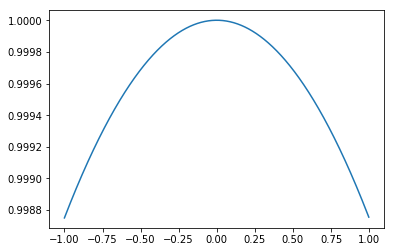

In [128]:
plt.plot(svec, np.abs(initpcf(svec)))

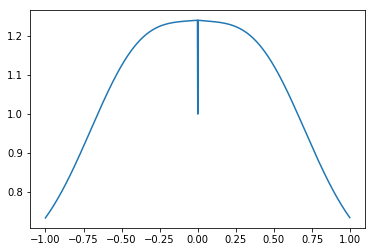

In [129]:
cf = initpcf(svec)
cf = ds*np.dot(kernelmat,cf)
plt.plot(svec, np.abs(cf))

In [43]:
kernelmat[sres//2+3,sres//2+3]

(2.0275083312646847-5.8296364669359517e-16j)

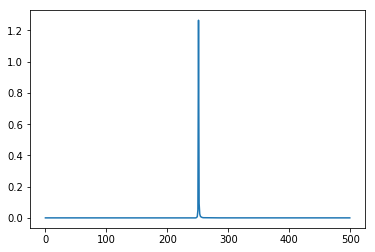

In [35]:
plt.plot(ds*np.real(kernelmat[sres//2+1,]))

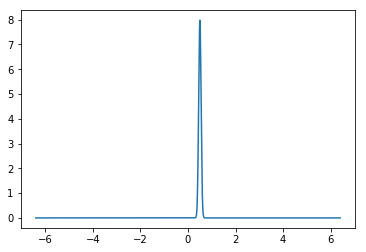

In [70]:
# set up x grid for plotting
Nxplot = int(1/(sres*ds)
Lplot = 12.8
dxplot = 1/(sres*ds)
xplot = np.arange(-Lplot/2,Lplot/2,dxplot)

# initial PDF
plt.plot(xplot, initp(xplot))

In [71]:
# Fourier matrix
fouriermat = np.zeros((Nxplot,sres),dtype='D')
for i in range(Nxplot):
    fouriermat[i,] = np.exp(-1j*uvec*xplot[i])/(2.0*np.pi)


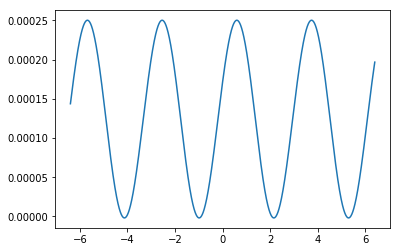

In [72]:
# PDF at next time step
plt.plot(xplot, np.real(dxplot*np.dot(fouriermat,cf)))

In [31]:
np.save(file='kernelmat1',arr=kernelmat)